# Notebook to visualise/analyse model predictions

In [50]:
import sys
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
sys.path.append(os.path.dirname(os.path.abspath('.')))

from dev.utils import load_wandb_model

model, cfg, train_loader, val_loader, test_loader, topo_data, metadata = load_wandb_model('tatlymbz', name='last.ckpt', device='cuda')

/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


Predicted raw dataset size: 1.36 GB
Predicted raw dataset size: 1.36 GB

Dataloaders and Topology Data Overview:
Batch size: 16
----------------------------------------------------------
Name                 | Samples      | Batches     
----------------------------------------------------------
Train Loader         | 23973        | 1498        
Val Loader           | 3424         | 214         
Test Loader          | 6849         | 428         

Topology Data:
Number of nodes: 207
Number of edges: 1515
----------------------------------------------------------
Imported model from run "tatlymbz".
  | Name                | Type              | Params
----------------------------------------------------------
0 | criterion           | L1Loss            | 0     
1 | input_encoder_patch | Linear            | 256   
2 | input_encoder_node  | Linear            | 128   
3 | edge_encoder        | Linear            | 256   
4 | gnns                | ModuleList        | 99.6 K
5 | U              

In [51]:
# Initialize lists to store predictions and ground truth
all_preds = []
all_true = []

# Disable gradient computation for inference
with torch.no_grad():
    for x, y, mask_x, mask_y in tqdm(test_loader):
        # Get predictions
        y_hat = model(x.to(model.device))
        
        # Unnormalize predictions and ground truth
        y_hat = y_hat * metadata['norm_std'] + metadata['norm_mean'] 
        y = y * metadata['norm_std'] + metadata['norm_mean']
        
        # Store predictions and ground truth
        all_preds.append(y_hat.cpu())
        all_true.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_true = torch.cat(all_true, dim=0)

print(f"Predictions shape: {all_preds.shape}")
print(f"Ground truth shape: {all_true.shape}")


  0%|          | 0/428 [00:00<?, ?it/s]

100%|██████████| 428/428 [00:16<00:00, 26.02it/s]


Predictions shape: torch.Size([6848, 207, 12])
Ground truth shape: torch.Size([6848, 207, 12])


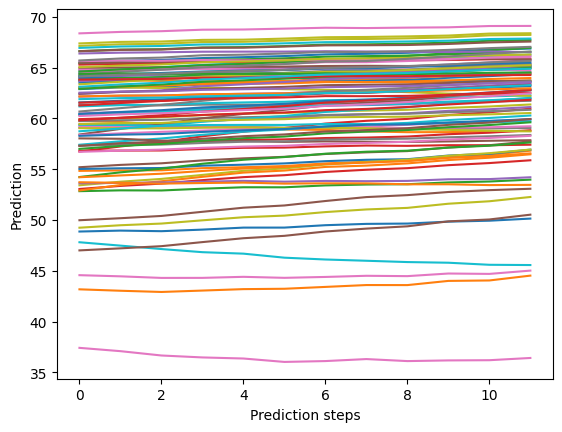

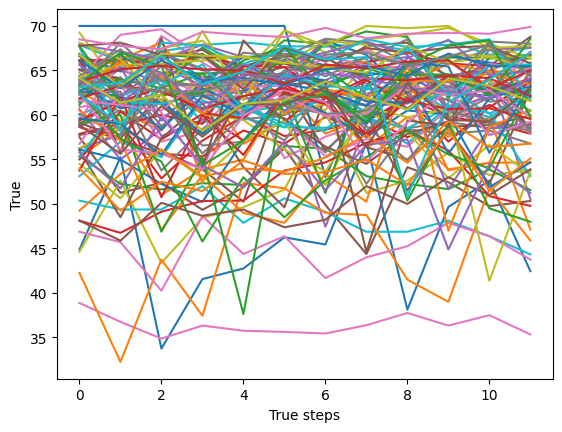

In [52]:
plt.plot(all_preds[0, :100, :].detach().numpy().T)
plt.xlabel('Prediction steps')
plt.ylabel('Prediction')
plt.show()

plt.plot(all_true[0, :100, :].detach().numpy().T)
plt.xlabel('True steps')
plt.ylabel('True')
plt.show()

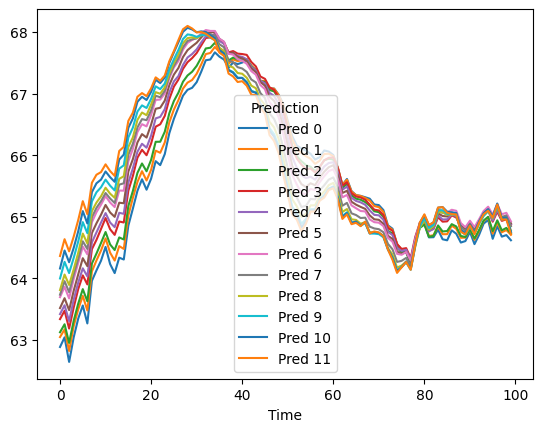

In [53]:
total_steps = 100
plt.plot(all_preds[:total_steps, 0, :].detach().numpy(), label=[f'Pred {i}' for i in range(all_preds.shape[2])])
plt.xlabel('Time')
plt.legend(title='Prediction')

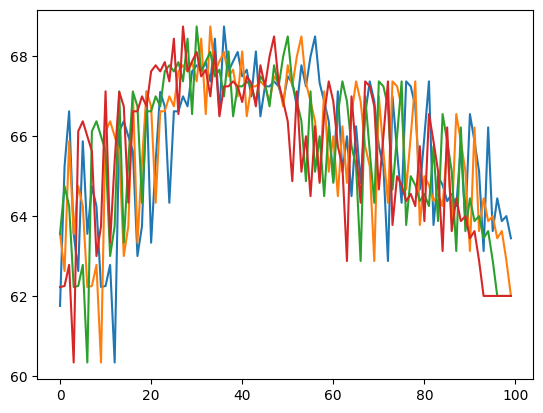

In [102]:

plt.plot(all_true[:total_steps, 0, ::3].detach().numpy(), label='True')

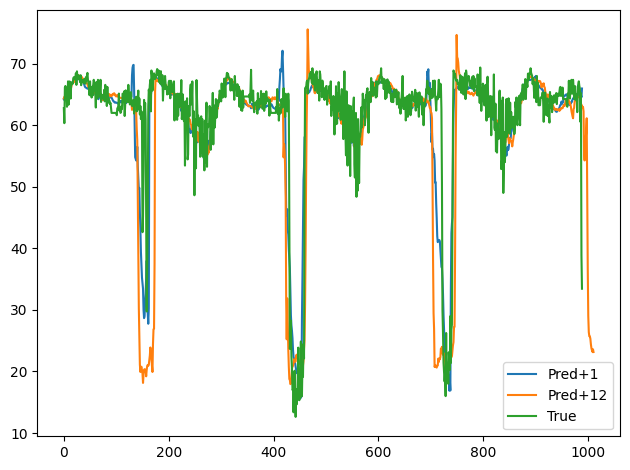

In [64]:
from matplotlib import pyplot as plt

horizon_steps = [0, 11]
max_horizon = 11
total_steps = 1000

plt.plot(all_true[max_horizon:total_steps, 0, 0].detach().numpy().T, label='True')
for i in horizon_steps:
    plt.plot(all_preds[max_horizon-i:total_steps+i, 0, i].detach().numpy().T, label=f'Pred+{i+1}')
plt.legend()
plt.tight_layout()
plt.show()


### Checking validation loader missing rate

In [32]:
from model.dataset import create_dataloaders
from train.configs.utils import load_config

dataset = 'la'
cfg = load_config(configs_dir='/home/lc865/workspace/DL-GNNs/Temporal-Graph-MLP-Mixer/src/TGMM-1/train/configs', dataset_name=dataset)
train_loader, val_loader, test_loader, topo_data, metadata = create_dataloaders(cfg, raw_data_dir='/mnt/cephfs/store/gr-mc2473/lc865/workspace/GNN/data', num_workers=1)

/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


Predicted raw dataset size: 1.36 GB
Predicted raw dataset size: 1.36 GB

Dataloaders and Topology Data Overview:
Batch size: 16
----------------------------------------------------------
Name                 | Samples      | Batches     
----------------------------------------------------------
Train Loader         | 23973        | 1498        
Val Loader           | 3424         | 214         
Test Loader          | 6849         | 428         

Topology Data:
Number of nodes: 207
Number of edges: 1515
----------------------------------------------------------


100%|██████████| 1498/1498 [00:06<00:00, 247.74it/s]


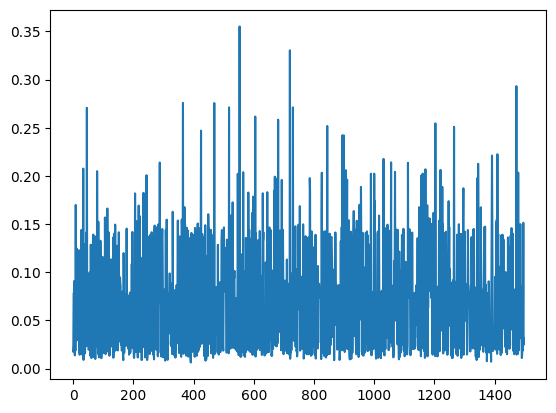

In [13]:
missing_rates = []
for batch in tqdm(train_loader):
    x, y, mask_x, mask_y = batch
    missing_rate = torch.mean((~mask_y).float()).item()
    missing_rates.append(missing_rate)
plt.plot(missing_rates)
plt.show()

100%|██████████| 214/214 [00:00<00:00, 289.05it/s]


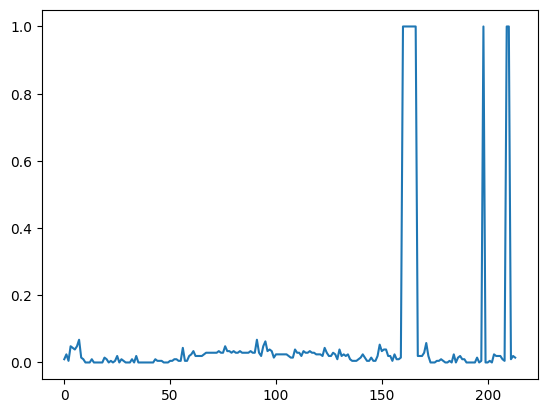

In [37]:
missing_rates = []
for batch in tqdm(val_loader):
    x, y, mask_x, mask_y = batch
    missing_rate = torch.mean((~mask_y[0, :, 0]).float()).item()  # masky: torch.Size([16, 207, 12])
    missing_rates.append(missing_rate)
plt.plot(missing_rates)
plt.show()

In [25]:
missing_rates.sort()
missing_rates[180:]

[0.0405847430229187,
 0.04199375957250595,
 0.04244665801525116,
 0.043000202625989914,
 0.04360406473278999,
 0.043805353343486786,
 0.0490388497710228,
 0.05064915493130684,
 0.05112721398472786,
 0.05253623053431511,
 0.05882649123668671,
 0.06031098961830139,
 0.061141304671764374,
 0.06438707560300827,
 0.06989734619855881,
 0.08330817520618439,
 0.08967391401529312,
 0.11380334198474884,
 0.11798007041215897,
 0.2300473004579544,
 0.27309781312942505,
 0.2971517741680145,
 0.3023097813129425,
 0.411408007144928,
 0.5341183543205261,
 0.8132296800613403,
 0.9948671460151672,
 0.9949929714202881,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

100%|██████████| 428/428 [00:02<00:00, 183.12it/s]


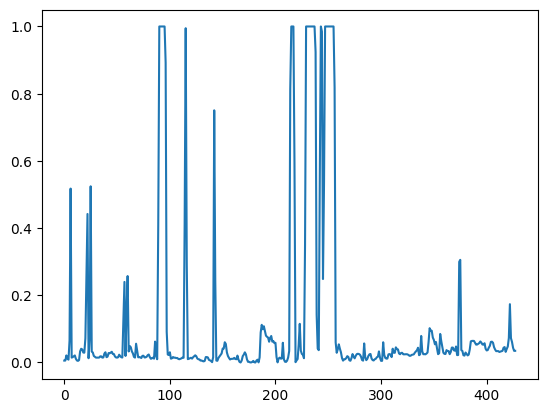

In [15]:
missing_rates = []
for batch in tqdm(test_loader):
    x, y, mask_x, mask_y = batch
    missing_rate = torch.mean((~mask_y).float()).item()
    missing_rates.append(missing_rate)
plt.plot(missing_rates)
plt.show()

In [96]:
x, y, mask_x, mask_y = val_loader.dataset.dataset[val_loader.dataset.indices]
print(f'Missing rate: {torch.mean((~mask_y).float()).item()}')



Missing rate: 0.0696740671992302


In [95]:
torch.sum(mask_x == mask_y) / mask_x.numel()

tensor(0.9611)

In [1]:
x, y, mask_x, mask_y = train_loader.dataset.dataset[train_loader.dataset.indices]
print(f'Missing rate: {torch.mean((~mask_y).float()).item()}')


NameError: name 'train_loader' is not defined

In [41]:
loss = torch.nn.L1Loss()
all_false_mask = torch.zeros_like(mask_y, dtype=bool)
loss(y[all_false_mask], y[all_false_mask])


tensor(nan)